# Stochastisches Bilevel-Modell für PV-Investitions- und Betriebsentscheidungen

Dieses Notebook implementiert ein stochastisches Bilevel-Modell, das eine Investitionsentscheidung für eine Photovoltaik-(PV)-Anlage und dazugehörige operative Entscheidungen (Netzbezug und Einspeisung) integriert. Der Code nutzt Julia, JuMP und Ipopt und bildet das in der zugehörigen PDF beschriebene Modell ab.

In [57]:
using Pkg
Pkg.activate(".")
#Pkg.instantiate()

  Activating project at `c:\Users\nikla\git\AMOProject`


In [58]:
# Pkg.add("JuMP")
# Pkg.add("Plots")
# Pkg.add("JSON")
# Pkg.add("CPLEX")
# Pkg.add("DataFrames")

In [59]:
using JuMP, Plots, JSON, CPLEX, DataFrames

## Parameterdefinitionen

Hier werden die grundlegenden Parameter definiert, wie etwa die Anzahl der Zeitschritte, Investitionskosten, Strompreise sowie Parameter zur Modellierung der PV-Leistung und Emissionen.

In [60]:
# Anzahl der Zeitperioden (z.B. 12 Monate * 24 Stunden)
T = 288

# Anzahl der Szenarien pro Zeitschritt
num_scenarios = 5

# Investitionskosten (Beispielwert)
#C_inv = 10 * 12

# Social Cost of Carbon (€/t CO2)
SCC = 100

# Kosten für Netzbezug und Erlös aus Einspeisung (€/kWh)
c_grid_buy = 0.47
c_grid_feed = 0.083

# Emissionsintensität (tCO2/kWh)
e_grid = 0.00038

# PV-Parameter
η_0 = 0.18      # Nominale PV-Wirkungsgrad
β = 0.004       # Temperaturkoeffizient pro °C
T_ref = 25      # Referenztemperatur in °C

# -- Parameter für Investitionskosten-Formel nach Bergner (2019)
I0   = 1923    # €/kW
p    = 0.16     # Skalierungsparameter
MwSt = 0.19     # 19% Mehrwertsteuer
r    = 0.0275   # Zinssatz pro Jahr (2,75%)
n    = 25       # Nutzungsdauer in Jahren

# -- Aus der Annuitätenformel: a = r * (1+r)^n / ((1+r)^n - 1)
#    Diesen Faktor brauchen wir, um die einmaligen Investitionskosten
#    auf jährliche Kosten A umzurechnen.
function annuity_factor(r, n)
    return r * (1+r)^n / ((1+r)^n - 1)
end
a = annuity_factor(r, n)
nothing

## Definition der Effizienzfunktion

Die Funktion `efficiency` berechnet den temperaturabhängigen PV-Wirkungsgrad.

In [61]:
function efficiency(T_t)
    return η_0 * (1 - β * (T_t - T_ref)) / 1000
end

efficiency (generic function with 1 method)

## Lade Szenario Daten

In [62]:
# Szenarien und wahrscheinlichkeiten aus JSON-Dateien laden
all_scenarios = JSON.parsefile("data/results/all_scenarios.json")
all_probabilities = JSON.parsefile("data/results/all_probabilities.json")

# Konvertiere JSON-Arrays in Julia-Arrays
#'G(i) (Globalstrahlung)', 'T2m (Temperatur)', 'Global_active_power'
all_scenarios = [[convert(Array{Float64,1}, scenario) for scenario in scenarios] for scenarios in all_scenarios]
all_probabilities = [convert(Vector{Float64}, probs) for probs in all_probabilities]
println(all_scenarios[1])
println(all_probabilities[1])
nothing

[[0.0, 4.8081650263075, 0.8068817376032622], [0.0, -5.771263723091087, 1.2615778196897662], [0.0, 8.883335728643948, 0.5962195138137514], [0.0, -1.6843232198752234, 0.9976414604579212], [0.0, 1.3554820136203587, 0.9259867657899179]]
[0.272, 0.068, 0.161, 0.22, 0.279]


In [63]:
T_total = length(all_scenarios)  # 288
num_scenarios = length(all_scenarios[1])  # 5

S_t_omega = [[all_scenarios[t][ω][1] for ω in 1:num_scenarios] for t in 1:T_total]  # Solar
L_t_omega = [[all_scenarios[t][ω][3] for ω in 1:num_scenarios] for t in 1:T_total]  # Load
T_t_omega = [[all_scenarios[t][ω][2] for ω in 1:num_scenarios] for t in 1:T_total]  # Temperature

# Szenario wahrscheinlichkeiten
Φ_t_omega = [all_probabilities[t] for t in 1:T_total]  
nothing

## Testausgabe für den ersten Zeitschritt

Wir geben die für den ersten Zeitschritt (erste Stunde im Januar) generierten Werte aus.

In [64]:
println("Erste Stunde im Januar:")
println("Solar: ", S_t_omega[1])
println("Verbrauch: ", L_t_omega[1])
println("Temperatur: ", T_t_omega[1])
println("Szenario-Wahrscheinlichkeiten: ", Φ_t_omega[1])

Erste Stunde im Januar:
Solar: [0.0, 0.0, 0.0, 0.0, 0.0]
Verbrauch: [0.8068817376032622, 1.2615778196897662, 0.5962195138137514, 0.9976414604579212, 0.9259867657899179]
Temperatur: [4.8081650263075, -5.771263723091087, 8.883335728643948, -1.6843232198752234, 1.3554820136203587]
Szenario-Wahrscheinlichkeiten: [0.272, 0.068, 0.161, 0.22, 0.279]


## Erstellung und Lösung des Optimierungsmodells

Das Optimierungsmodell wird in zwei Ebenen aufgeteilt:

- **Obere Ebene:** Investitionsentscheidung (Variable y_PV) unter Berücksichtigung der jährlichen Investitionskosten.
- **Untere Ebene:** Operative Entscheidungen (Netzbezug G_in und Einspeisung G_out) für jeden Zeitschritt und jedes Szenario. Die KKT-Bedingungen der unteren Ebene werden verwendet, um das bilevel-Problem in ein Single-Level-Problem zu transformieren.
- **Big M Methode:** Zur Linearisierung des Single-Level-Problems verwenden wir die Big-M-Methode

Anhand der Energiebilanz wird sichergestellt, dass der Verbrauch durch PV-Erzeugung, Netzbezug und Einspeisung gedeckt wird.

In [65]:
function buildAndOptimize()
    model = Model(CPLEX.Optimizer)
    set_silent(model)

    # Obere Ebene: Investitionsentscheidung (Leader)
    @variable(model, 0 <= y_PV)

    # Untere Ebene: Operationelle Variablen (Follower)
    @variable(model, G_in[1:T, 1:num_scenarios] >= 0)   # Netzimport
    @variable(model, G_out[1:T, 1:num_scenarios] >= 0)   # Netzexport

    # Dualvariablen für KKT-Bedingungen
    @variable(model, λ[1:T, 1:num_scenarios])
    @variable(model, nu_in[1:T, 1:num_scenarios] >= 0)
    @variable(model, nu_out[1:T, 1:num_scenarios] >= 0)
    @variable(model, z_in[1:T, 1:num_scenarios], Bin)
    @variable(model, z_out[1:T, 1:num_scenarios], Bin)

    # I_pv = (I0 * y_PV^(-p)) * y_PV * (1 + MwSt)
    #      = I0 * y_PV^(1-p) * (1 + MwSt)
    @expression(model, I_pv, I0 * (0.2*y_PV) * (1 + MwSt))

    # Jährliche Investitionskosten via Annuitätenformel
    @expression(model, A, I_pv * a)


    M = 1_000  # Big-M Wert

    for t in 1:T, ω in 1:num_scenarios
        # Berechnung der PV-Erzeugung als fester Wert unter Nutzung der Effizienzfunktion
        P_PV_val = efficiency(T_t_omega[t][ω]) * S_t_omega[t][ω]
        
        # Primal-Nebenbedingung: Energiebilanz
        @constraint(model, L_t_omega[t][ω] == y_PV * P_PV_val + G_in[t, ω] - G_out[t, ω])
        
        # Stationaritätsbedingungen (Gradienten der Lagrangefunktion)
        @constraint(model, c_grid_buy - λ[t, ω] - nu_in[t, ω] == 0)
        @constraint(model, -c_grid_feed + λ[t, ω] - nu_out[t, ω] == 0)
        
        # Big-M Formulierung für Komplementaritätsbedingungen
        @constraint(model, G_in[t, ω] <= M * z_in[t, ω])
        @constraint(model, nu_in[t, ω] <= M * (1 - z_in[t, ω]))
        @constraint(model, G_out[t, ω] <= M * z_out[t, ω])
        @constraint(model, nu_out[t, ω] <= M * (1 - z_out[t, ω]))
    end

    # Zielfunktion: Minimierung der Investitionskosten plus der gewichteten Betriebs- und Emissionskosten
    @objective(model, Min,
        (A/365)*12 +
        sum(Φ_t_omega[t][ω] * (c_grid_buy * G_in[t, ω] - c_grid_feed * G_out[t, ω] + SCC * e_grid * G_in[t, ω])
            for t in 1:T, ω in 1:num_scenarios)
    )

    optimize!(model)
    return model
end

model = buildAndOptimize()
nothing

In [66]:
# Display optimal value for y_PV
println("Optimal m^2: ", value(model[:y_PV]))

# Display total cost (objective value)
total_cost = objective_value(model)
println("Total Cost: ", total_cost)
println("Total Cost Yearly: ", total_cost/12*365)

println()

# Calculate and display the breakdown of costs
# 1. Investment Cost (A) - Annualized cost
investment_cost = value(model[:A]) * 12 / 365  # Annualized investment cost
println("Investment Cost: ", investment_cost)

# 2. Operation Cost (excluding SCC)
operation_cost = sum(
    value(Φ_t_omega[t][ω]) * (
        value(c_grid_buy) * value(model[:G_in][t, ω]) - value(c_grid_feed) * value(model[:G_out][t, ω])
    ) 
    for t in 1:T, ω in 1:num_scenarios
)
println("Operation Cost: ", operation_cost)

# 3. SCC (Emission) Cost
scc_cost = sum(value(Φ_t_omega[t][ω]) * value(SCC) * value(e_grid) * value(model[:G_in][t, ω]) 
               for t in 1:T, ω in 1:num_scenarios)
println("SCC (Emission) Cost: ", scc_cost)

Optimal m^2: 59.24935572899928
Total Cost: 115.02995372187446
Total Cost Yearly: 3498.827759040348

Investment Cost: 49.782128171302425
Operation Cost: 58.21027402807374
SCC (Emission) Cost: 7.037551522498244


## Plotting

Compute G-in and G-out series with most probable scenarios in every time step

In [67]:
most_probable_G_out = Float64[]
most_probable_G_in = Float64[]

G_out_values = [value(model[:G_out][t, ω]) for t in 1:T, ω in 1:num_scenarios]
G_out_matrix = reshape(G_out_values, T, num_scenarios)

G_in_values = [JuMP.value(model[:G_in][t, ω]) for t in 1:T, ω in 1:num_scenarios]
G_in_matrix = reshape(G_in_values, T, num_scenarios)

for t in 1:T_total
    # Find the index of the scenario with the highest probability for time t
    most_probable_scenario = argmax(Φ_t_omega[t])[1] 
    
    push!(most_probable_G_out, G_out_matrix[t, most_probable_scenario])
    push!(most_probable_G_in, G_in_matrix[t, most_probable_scenario])  
end

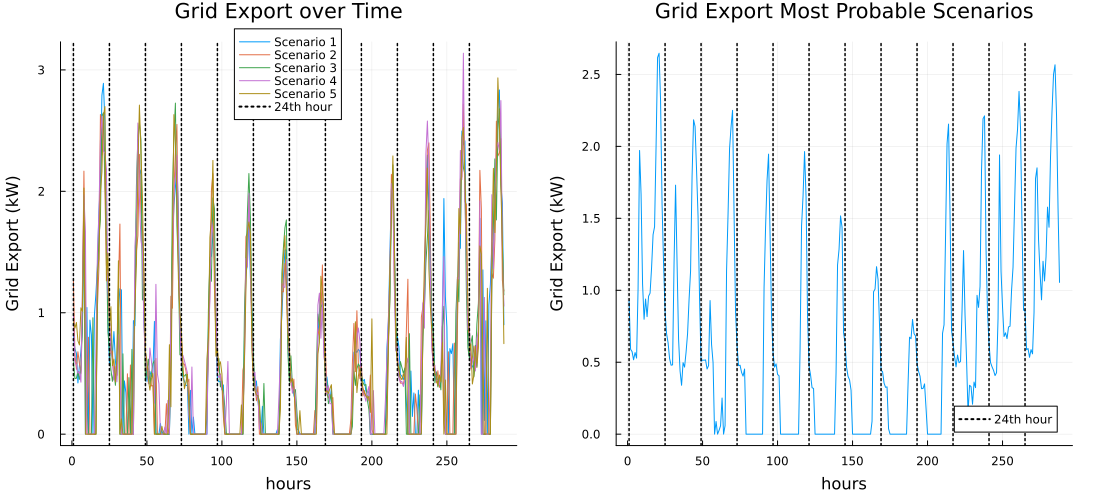

In [68]:
using Plots
using Plots.PlotMeasures

# Create the plot and assign labels to each scenario (column)
p = plot(1:T, G_in_matrix, xlabel="hours", ylabel="Grid Export (kW)", title="Grid Export over Time",
         label=permutedims(["Scenario $ω" for ω in 1:num_scenarios]))  # Transpose the label array

# Add vertical dotted lines every 24 steps
for i in 1:24:T
    vline!(p, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false)  # No label for vertical lines
end
plot!(p, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label
plot!(p, legend=(0.47, 1))
# plot most probable
p_probable = plot(1:T, most_probable_G_in, title="Grid Export Most Probable Scenarios", label = false)
for i in 1:24:T
    vline!(p_probable, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false, xlabel="hours", ylabel="Grid Export (kW)",)  # No label for vertical lines
end
plot!(p_probable, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label

# Display the plot
plot(p, p_probable, layout=(1, 2), size=(1100, 500), margin=5mm)

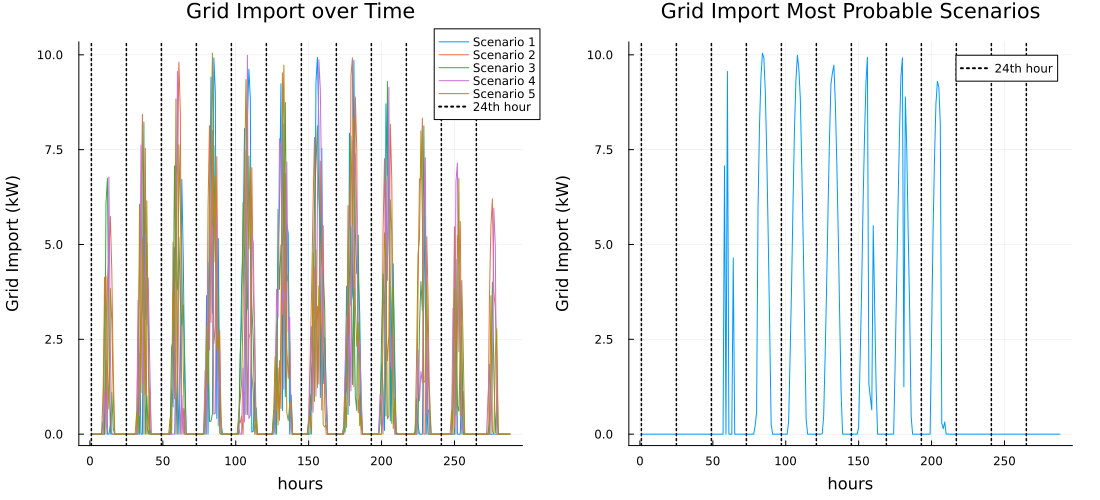

In [69]:
using Plots
using Plots.PlotMeasures

# Create the plot and assign labels to each scenario (column)
p = plot(1:T, G_out_matrix, xlabel="hours", ylabel="Grid Import (kW)", title="Grid Import over Time",
         label=permutedims(["Scenario $ω" for ω in 1:num_scenarios]))  # Transpose the label array

# Add vertical dotted lines every 24 steps
for i in 1:24:T
    vline!(p, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false)  # No label for vertical lines
end
plot!(p, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label
plot!(p, legend=(0.89, 1.0))
# plot most probable
p_probable = plot(1:T, most_probable_G_out, title="Grid Import Most Probable Scenarios", label = false)
for i in 1:24:T
    vline!(p_probable, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false, xlabel="hours", ylabel="Grid Import (kW)",)  # No label for vertical lines
end
plot!(p_probable, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label

# Display the plot
plot(p, p_probable, layout=(1, 2), size=(1100, 500), margin=5mm)


In [70]:
most_probable_scenario = argmax(sum(Φ_t_omega[t][1] for t in 1:T))

ω_max = argmax(sum(Φ_t_omega[t][1] for t in 1:T))  # Most probable scenario index

solar_generated_most_probable = [value(model[:y_PV]) * efficiency(T_t_omega[t][ω_max]) * S_t_omega[t][ω_max] for t in 1:T]
solar_exported_most_probable = [value(model[:G_out][t, ω_max]) for t in 1:T]
solar_used_most_probable = [solar_generated_most_probable[t] - solar_exported_most_probable[t] for t in 1:T]

# Convert to yearly energy (kWh)
total_solar_used_most_probable = sum(solar_used_most_probable) / 12 * 365
total_solar_generated = sum(solar_generated_most_probable) / 12 * 365
total_solar_exported = sum(solar_exported_most_probable) / 12 * 365

sum_G_in = sum(most_probable_G_in)/12*365
sum_G_out = sum(most_probable_G_out)/12*365

# Check energy balance
println("Total Solar Generated: ", total_solar_generated)
println("Load Served (Solar Used): ", total_solar_used_most_probable)
println("Grid Export: ", total_solar_exported)
println("Energy Balance Check: ", total_solar_generated ≈ (total_solar_used_most_probable + total_solar_exported))

Total Solar Generated: 13836.994888281683
Load Served (Solar Used): 3775.195656422164
Grid Export: 10061.79923185952
Energy Balance Check: true


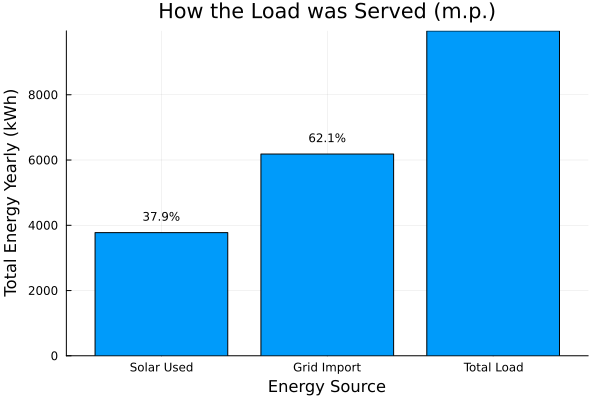

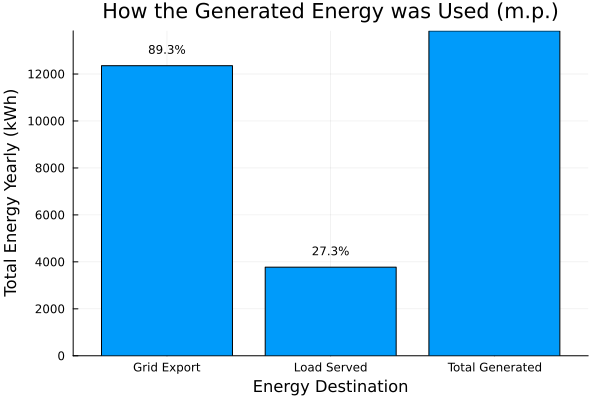

In [71]:
using Plots
using DataFrames

# Create a DataFrame for Load Breakdown
load_categories = ["Solar Used", "Grid Import", "Total Load"]
load_values = [total_solar_used_most_probable, sum_G_in, total_solar_used_most_probable + sum_G_in]
df_load = DataFrame(group=load_categories, value=load_values)

# Plot 1: How the Load was Served
p1 = bar(df_load.group, df_load.value,
         xlabel="Energy Source",
         ylabel="Total Energy Yearly (kWh)",
         title="How the Load was Served (m.p.)",
         legend=:none,
         yformatter=:plain)

# Add percentages above each bar in the first plot
for row in eachrow(df_load[1:2, :])  # Only the first two categories (Solar Used, Grid Import)
    percent = calculate_percentage(row.value, df_load.value[3])
    annotate!(p1, row.group, row.value + 0.05 * maximum(df_load.value), text("$(round(percent, digits=1))%", 8, :black, :center))
end

# Display the first plot
display(p1)

# Create a DataFrame for Solar Generation Usage
gen_categories = ["Grid Export", "Load Served", "Total Generated"]
gen_values = [sum_G_out, total_solar_used_most_probable, total_solar_generated]
df_gen = DataFrame(group=gen_categories, value=gen_values)

# Plot 2: How the Generated Energy was Used
p2 = bar(df_gen.group, df_gen.value,
         xlabel="Energy Destination",
         ylabel="Total Energy Yearly (kWh)",
         title="How the Generated Energy was Used (m.p.)",
         legend=:none,
         yformatter=:plain)

# Add percentages above each bar in the second plot
for row in eachrow(df_gen[1:2, :])  # Only the first two categories (Grid Export, Load Served)
    percent = calculate_percentage(row.value, df_gen.value[3])
    annotate!(p2, row.group, row.value + 0.05 * maximum(df_gen.value), text("$(round(percent, digits=1))%", 8, :black, :center))
end

# Display the second plot
display(p2)


## Sensitivity Analysis

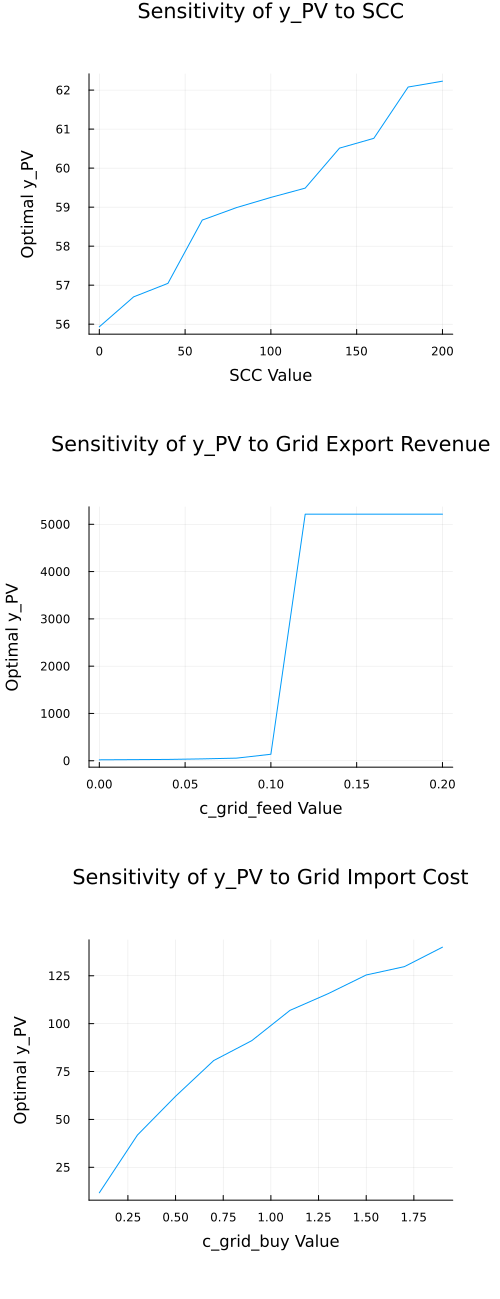

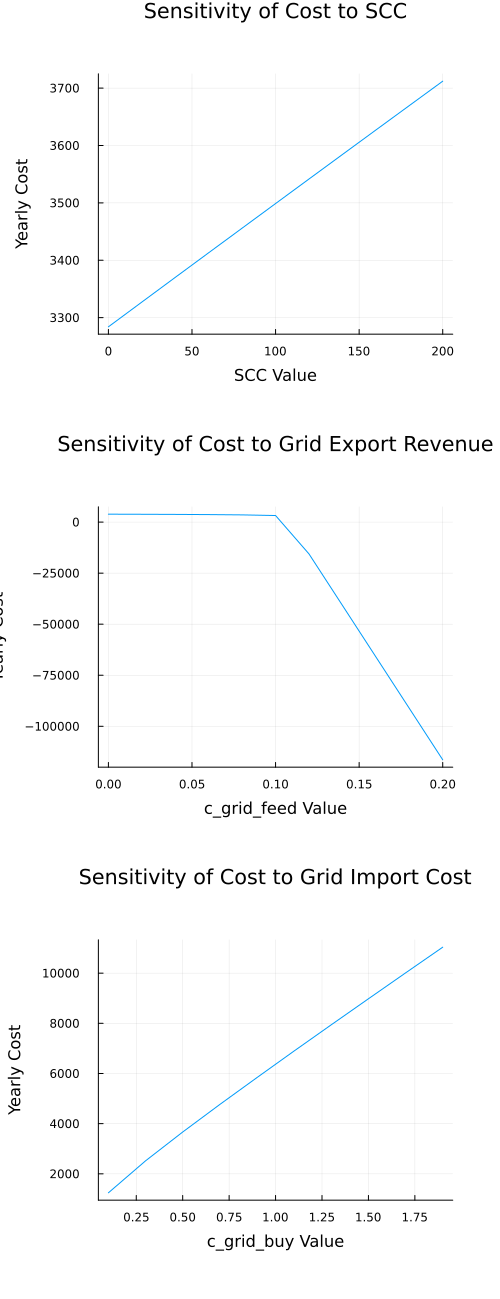

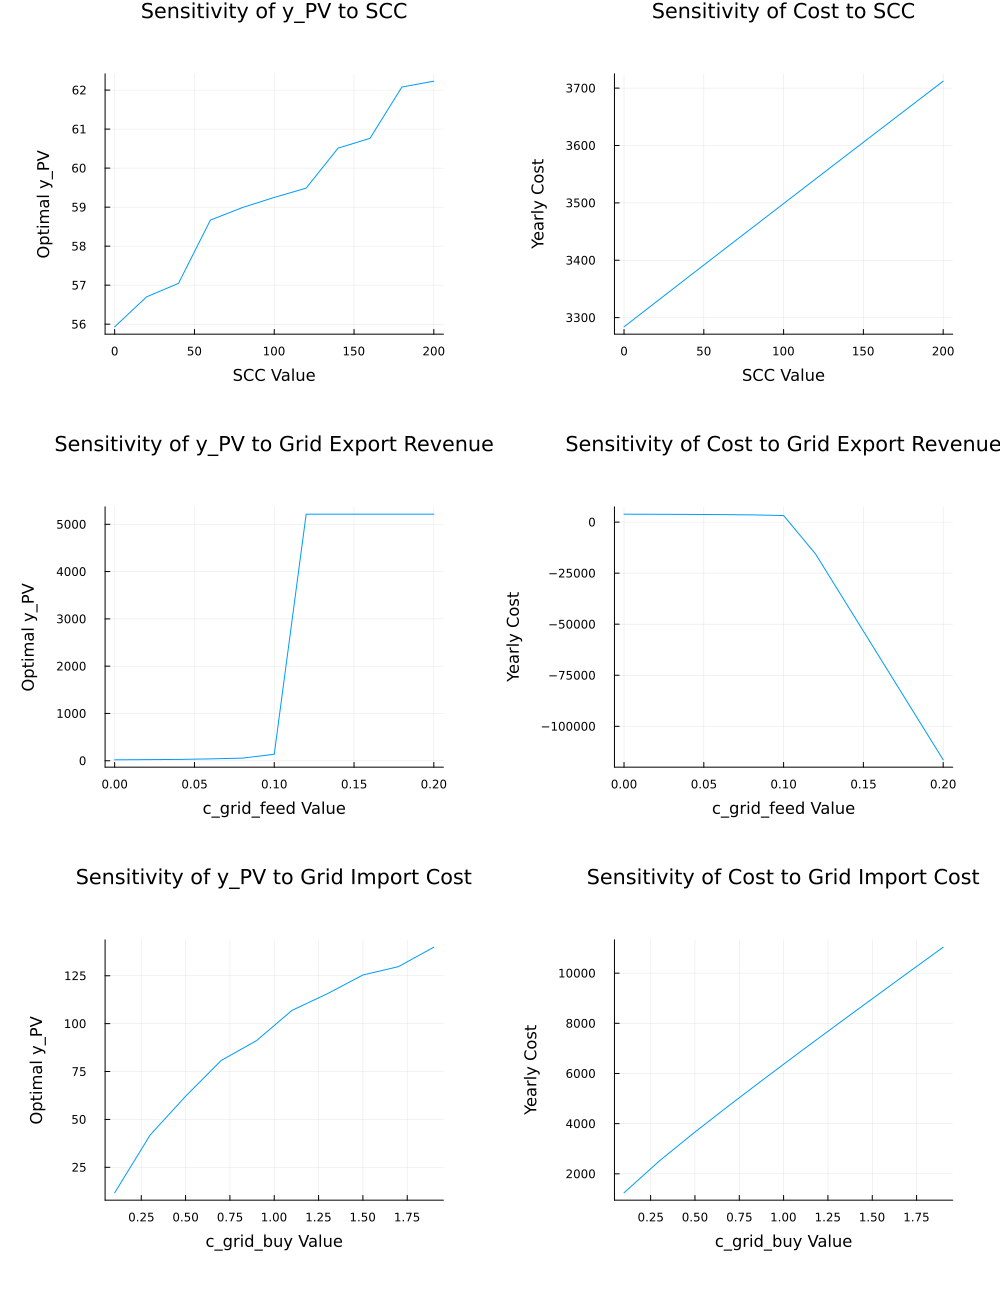

In [ ]:
# Sensitivity analysis for SCC
SCC_values = 0:20:200  
y_PV_values_SCC = []
cost_SCC = []

# Loop to update SCC values and optimize the model
for SCC_value in SCC_values
    SCC = SCC_value  # Update SCC value
    
    # Re-build
    model = buildAndOptimize()
    
    # Collect the results
    push!(y_PV_values_SCC, value(model[:y_PV]))
    push!(cost_SCC, objective_value(model)/12*365)
end
SCC = 100

# Sensitivity analysis for Grid Import Cost
c_grid_buy_values = 0.1:0.2:2 
y_PV_values_grid_import = []
cost_grid_import = []

# Loop to update grid import cost and optimize the model
for c_grid_buy_value in c_grid_buy_values
    c_grid_buy = c_grid_buy_value  # Update grid import cost value
    
    # Re-build
    model = buildAndOptimize()
    
    # Collect the results
    push!(y_PV_values_grid_import, value(model[:y_PV]))
    push!(cost_grid_import, objective_value(model)/12*365)
end
c_grid_buy = 0.47

# Sensitivity analysis for Grid Export Cost
c_grid_feed_values = 0:0.02:0.2 
y_PV_values_grid_export = []
cost_grid_export = []

# Loop to update grid import cost and optimize the model
for c_grid_feed_value in c_grid_feed_values
    c_grid_feed = c_grid_feed_value  # Update grid import cost value
    
    # Re-build
    model = buildAndOptimize()
    
    # Collect the results
    push!(y_PV_values_grid_export, value(model[:y_PV]))
    push!(cost_grid_export, objective_value(model)/12*365)
end
c_grid_feed = 0.083

sens_ypv_scc = plot(SCC_values, y_PV_values_SCC, xlabel="SCC Value", ylabel="Optimal y_PV", title="Sensitivity of y_PV to SCC", label=false, legend=:topright)

sens_ypv_export = plot(c_grid_feed_values, y_PV_values_grid_export, xlabel="c_grid_feed Value", ylabel="Optimal y_PV", title="Sensitivity of y_PV to Grid Export Revenue", label=false, legend=:topright)

sens_ypv_import = plot(c_grid_buy_values, y_PV_values_grid_import, xlabel="c_grid_buy Value", ylabel="Optimal y_PV", title="Sensitivity of y_PV to Grid Import Cost", label=false, legend=:topright)

# Combine sensitivity plots for y_PV
merge1 = plot(sens_ypv_scc, sens_ypv_export, sens_ypv_import, layout=(3, 1), size=(500, 1300), margin=10mm, yformatter=:plain)
display(merge1)

sens_cost_scc = plot(SCC_values, cost_SCC, xlabel="SCC Value", ylabel="Yearly Cost", title="Sensitivity of Cost to SCC", label=false, legend=:topright)

sens_cost_export = plot(c_grid_feed_values, cost_grid_export, xlabel="c_grid_feed Value", ylabel="Yearly Cost", title="Sensitivity of Cost to Grid Export Revenue", label=false, legend=:topright)

sens_cost_import = plot(c_grid_buy_values, cost_grid_import, xlabel="c_grid_buy Value", ylabel="Yearly Cost", title="Sensitivity of Cost to Grid Import Cost", label=false, legend=:topright)


# Combine sensitivity plots for costs
merge2 = plot(sens_cost_scc, sens_cost_export, sens_cost_import, layout=(3, 1), size=(500, 1300), margin=10mm, yformatter=:plain)
display(merge2)

merge3 = plot(sens_ypv_scc, sens_cost_scc, sens_ypv_export, sens_cost_export, sens_ypv_import, sens_cost_import,
 layout=(3, 2), size=(1000, 1300), margin=10mm, yformatter=:plain)
display(merge3)


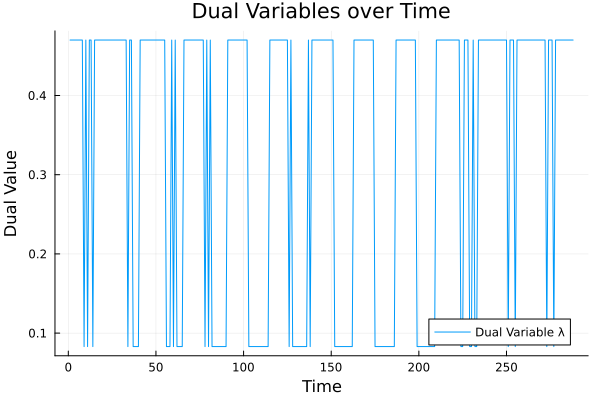

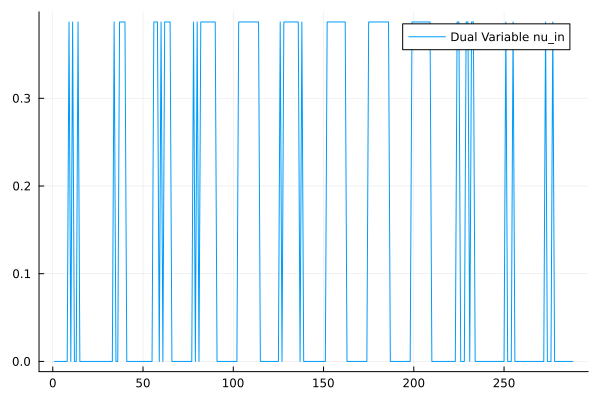

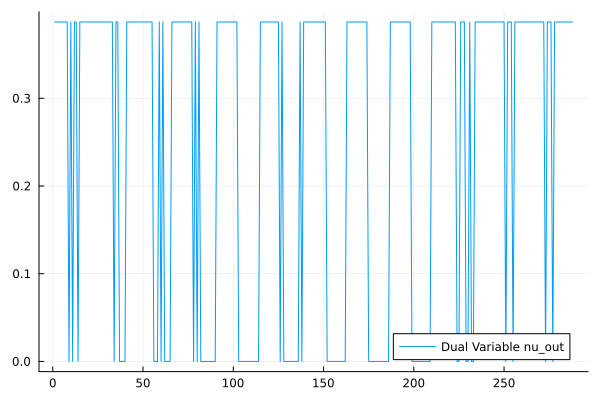

In [73]:
model = buildAndOptimize()

dual_lambda = [JuMP.value(model[:λ][t, ω]) for t in 1:T, ω in 1:1]
dual_nu_in = [JuMP.value(model[:nu_in][t, ω]) for t in 1:T, ω in 1:1]
dual_nu_out = [JuMP.value(model[:nu_out][t, ω]) for t in 1:T, ω in 1:1]

# Reshape them to match the number of time steps (T)
dual_nu_in_matrix = reshape(dual_nu_in, T, 1)
dual_nu_out_matrix = reshape(dual_nu_out, T, 1)

# Plot dual variable λ, nu_in, and nu_out
p1 = plot(1:T, dual_lambda, label="Dual Variable λ", xlabel="Time", ylabel="Dual Value", title="Dual Variables over Time")
p2 = plot(1:T, dual_nu_in_matrix, label="Dual Variable nu_in")
p3 = plot(1:T, dual_nu_out_matrix, label="Dual Variable nu_out")

# Display the plot
display(p1)
display(p2)
display(p3)